In [1]:
import tqdm
import warnings
import multiprocessing
import cvxpy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
def check_feasibility(L, a, b):
    x = cp.Variable(len(a))
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(cp.Maximize(0), constraints)
    problem.solve()    
    return problem.status in {"optimal", "feasible"}


def solve(L, a, b, metric):

    x = cp.Variable(len(a))

    if metric == "sw":
        objective = cp.Maximize(cp.sum(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    elif (metric == "pf") or (metric == 1):
        objective = cp.Maximize(cp.sum(cp.log(x) + cp.log(cp.multiply(-0.5*a**2, x) + b - L)))
    elif metric == "mm":
        objective = cp.Maximize(cp.min(-0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)))
    else:
        y = -0.5*cp.multiply(a, x**2) + cp.multiply(b - L, x)
        objective = cp.Maximize(cp.sum(cp.power(y, 1 - metric))/(1 - metric))
               
    constraints = [x <= 2*(b - L)/a, x >= 0, cp.sum(x) == L]
    problem = cp.Problem(objective, constraints)
    problem.solve(solver="ECOS", abstol=1e-6)

    user_surplus = -0.5*a*x.value**2 + (b - L)*x.value
    surplus = np.sum(user_surplus)
    
    return problem.value, x.value, user_surplus, surplus


def solve_wrapper(params):
    
    L = params["L"]
    seed = params["seed"]
    n_users = params["n_users"]

    np.random.seed(seed)
    a = 1*np.random.rand(n_users) + 1
    b = (a + 1)*L + 10*np.random.rand(n_users) + 1
        
    try:
        warnings.simplefilter("error")
        assert check_feasibility(L, a, b), "infeasible"
        sw_val, sw_sol, sw_user_surplus, sw_surplus = solve(L, a, b, "sw")
        pf_val, pf_sol, pf_user_surplus, pf_surplus = solve(L, a, b, "pf")
        mm_val, mm_sol, mm_user_surplus, mm_surplus = solve(L, a, b, "mm")
        message = "success"

    except (Warning, cp.SolverError) as e:
        sw_val, sw_sol, sw_user_surplus, sw_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        pf_val, pf_sol, pf_user_surplus, pf_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        mm_val, mm_sol, mm_user_surplus, mm_surplus = np.nan, np.full(n_users, np.nan), np.full(n_users, np.nan), np.nan
        message = str(e)
        
    return dict(
        n_users=2*n_users, seed=seed, message=message, 
        sw_val=sw_val, sw_sol=sw_sol, sw_surplus=sw_surplus, sw_min_surplus=np.min(sw_user_surplus),
        pf_val=pf_val, pf_sol=pf_sol, pf_surplus=pf_surplus, pf_min_surplus=np.min(pf_user_surplus),
        mm_val=mm_val, mm_sol=mm_sol, mm_surplus=mm_surplus, mm_min_surplus=np.min(mm_user_surplus),
    )

In [3]:
%%time
params_list = [
    dict(L=L, n_users=n_users, seed=seed)
    for L in [1] 
    for n_users in np.append(np.arange(1, 8), 2**np.arange(3, 11))
    for seed in range(1000)
]

pool = multiprocessing.Pool(min(multiprocessing.cpu_count(), 100))
results = pool.map(solve_wrapper, params_list)
pool.close()

CPU times: user 619 ms, sys: 409 ms, total: 1.03 s
Wall time: 14.4 s


In [4]:
# calculate price of fairness/efficiency (pof/poe)
df = pd.DataFrame(results).dropna()

df["pf_pof"] = (df.sw_surplus - df.pf_surplus) / df.sw_surplus
df["mm_pof"] = (df.sw_surplus - df.mm_surplus) / df.sw_surplus

df["sw_poe"] = (df.mm_min_surplus - df.sw_min_surplus) / df.mm_min_surplus
df["pf_poe"] = (df.mm_min_surplus - df.pf_min_surplus) / df.mm_min_surplus

df.head()

,n_users,seed,message,sw_val,sw_sol,sw_surplus,sw_min_surplus,pf_val,pf_sol,pf_surplus,pf_min_surplus,mm_val,mm_sol,mm_surplus,mm_min_surplus,pf_pof,mm_pof,sw_poe,pf_poe
0,2,0,success,8.926300,[1.0000000000600031],8.926300,8.926300,2.140219,[0.9999999999707684],8.926300,8.926300,8.926300,[1.0000000000269205],8.926300,8.926300,8.149315e-11,3.021257e-11,-3.021257e-11,5.128058e-11
1,2,1,success,8.911756,[1.0000000000733564],8.911756,8.911756,2.153655,[0.9999999933610537],8.911756,8.911756,8.911756,[1.0000000000183382],8.911756,8.911756,6.178655e-09,5.064430e-11,-5.064430e-11,6.128011e-09
2,2,2,success,1.977260,[0.9999999999693615],1.977260,1.977260,0.509354,[0.9999999912023148],1.977260,1.977260,1.977260,[0.9999999999631939],1.977260,1.977260,5.583491e-09,3.928000e-12,-3.928000e-12,5.579563e-09
3,2,3,success,8.856877,[1.000000000059132],8.856877,8.856877,2.131772,[0.9999999890065869],8.856877,8.856877,8.856877,[1.0000000000274258],8.856877,8.856877,1.008492e-08,2.893053e-11,-2.893053e-11,1.005599e-08
4,2,4,success,7.455837,[0.9999999999820305],7.455837,7.455837,1.872533,[0.9999999917967866],7.455837,7.455837,7.455837,[1.0000000000032165],7.455837,7.455837,7.105511e-09,-1.839139e-11,1.839139e-11,7.123903e-09


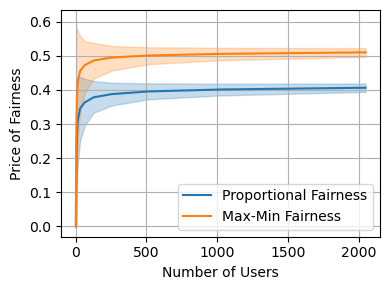

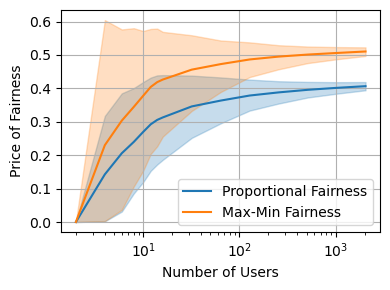

In [5]:
plt.figure(figsize=(4, 3))

# pof
df_mean = df.groupby("n_users")[["pf_pof", "mm_pof"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_pof", "mm_pof"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_pof", "mm_pof"]].quantile(0.95).reset_index()

plt.plot(df_mean.n_users, df_mean.pf_pof, label="Proportional Fairness", color="C0")
plt.plot(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness", color="C1")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=0)
plt.tight_layout()
plt.grid()
plt.show()


plt.figure(figsize=(4, 3))

# pof
df_mean = df.groupby("n_users")[["pf_pof", "mm_pof"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_pof", "mm_pof"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_pof", "mm_pof"]].quantile(0.95).reset_index()

plt.semilogx(df_mean.n_users, df_mean.pf_pof, label="Proportional Fairness", color="C0")
plt.semilogx(df_mean.n_users, df_mean.mm_pof, label="Max-Min Fairness", color="C1")
plt.fill_between(df_mean.n_users, df_05.pf_pof, df_95.pf_pof, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.mm_pof, df_95.mm_pof, color="C1", alpha=0.25)
plt.ylabel("Price of Fairness")
plt.xlabel("Number of Users")
plt.legend(loc=0)
plt.tight_layout()
plt.grid()
plt.show()

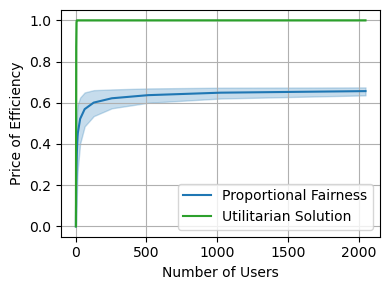

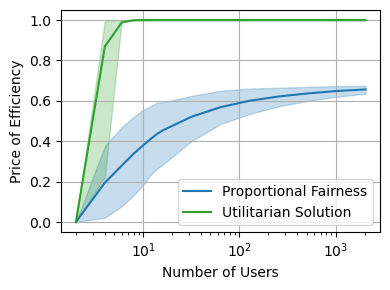

In [9]:
plt.figure(figsize=(4, 3))

# poe
df_mean = df.groupby("n_users")[["pf_poe", "sw_poe"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_poe", "sw_poe"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_poe", "sw_poe"]].quantile(0.95).reset_index()

plt.plot(df_mean.n_users, df_mean.pf_poe, label="Proportional Fairness", color="C0")
plt.plot(df_mean.n_users, df_mean.sw_poe, label="Utilitarian Solution", color="C2")
plt.fill_between(df_mean.n_users, df_05.pf_poe, df_95.pf_poe, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.sw_poe, df_95.sw_poe, color="C2", alpha=0.25)
plt.ylabel("Price of Efficiency")
plt.xlabel("Number of Users")
plt.legend(loc=0)
plt.tight_layout()
plt.grid()
plt.show()


plt.figure(figsize=(4, 3))

# poe
df_mean = df.groupby("n_users")[["pf_poe", "sw_poe"]].mean().reset_index()
df_05 = df.groupby("n_users")[["pf_poe", "sw_poe"]].quantile(0.05).reset_index()
df_95 = df.groupby("n_users")[["pf_poe", "sw_poe"]].quantile(0.95).reset_index()

plt.semilogx(df_mean.n_users, df_mean.pf_poe, label="Proportional Fairness", color="C0")
plt.semilogx(df_mean.n_users, df_mean.sw_poe, label="Utilitarian Solution", color="C2")
plt.fill_between(df_mean.n_users, df_05.pf_poe, df_95.pf_poe, color="C0", alpha=0.25)
plt.fill_between(df_mean.n_users, df_05.sw_poe, df_95.sw_poe, color="C2", alpha=0.25)
plt.ylabel("Price of Efficiency")
plt.xlabel("Number of Users")
plt.legend(loc=0)
plt.tight_layout()
plt.grid()
plt.show()